# Building Word Vectors through Co-Occurrence Matrices

In [1]:
import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from platform import python_version
assert int(python_version().split(".")[1]) >= 5, "Please upgrade your Python version. Your Python version is " + python_version()

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters') #to specify download location, optionally add the argument: download_dir='/specify/desired/path/'
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)

/home/shubham/anaconda3/envs/cs224n/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package reuters to /home/shubham/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


### Co-Occurrence

A co-occurrence matrix counts how often things co-occur in some environment. Given some word $w_i$ occurring in the document, we consider the *context window* surrounding $w_i$. Supposing our fixed window size is $n$, then this is the $n$ preceding and $n$ subsequent words in that document, i.e. words $w_{i-n} \dots w_{i-1}$ and $w_{i+1} \dots w_{i+n}$. We build a *co-occurrence matrix* $M$, which is a symmetric word-by-word matrix in which $M_{ij}$ is the number of times $w_j$ appears inside $w_i$'s window among all documents.

**Example: Co-Occurrence with Fixed Window of n=1**:

Document 1: "all that glitters is not gold"

Document 2: "all is well that ends well"


|     *    | `<START>` | all | that | glitters | is   | not  | gold  | well | ends | `<END>` |
|----------|-------|-----|------|----------|------|------|-------|------|------|-----|
| `<START>`    | 0     | 2   | 0    | 0        | 0    | 0    | 0     | 0    | 0    | 0   |
| all      | 2     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| that     | 0     | 1   | 0    | 1        | 0    | 0    | 0     | 1    | 1    | 0   |
| glitters | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| is       | 0     | 1   | 0    | 1        | 0    | 1    | 0     | 1    | 0    | 0   |
| not      | 0     | 0   | 0    | 0        | 1    | 0    | 1     | 0    | 0    | 0   |
| gold     | 0     | 0   | 0    | 0        | 0    | 1    | 0     | 0    | 0    | 1   |
| well     | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 1    | 1   |
| ends     | 0     | 0   | 1    | 0        | 0    | 0    | 0     | 1    | 0    | 0   |
| `<END>`      | 0     | 0   | 0    | 0        | 0    | 0    | 1     | 1    | 0    | 0   |

**Note:** In NLP, we often add `<START>` and `<END>` tokens to represent the beginning and end of sentences, paragraphs or documents. In this case we imagine `<START>` and `<END>` tokens encapsulating each document, e.g., "`<START>` All that glitters is not gold `<END>`", and include these tokens in our co-occurrence counts.

The rows (or columns) of this matrix provide one type of word vectors (those based on word-word co-occurrence), but the vectors will be large in general (linear in the number of distinct words in a corpus). Thus, our next step is to run *dimensionality reduction*. In particular, we will run *SVD (Singular Value Decomposition)*, which is a kind of generalized *PCA (Principal Components Analysis)* to select the top $k$ principal components. Here's a visualization of dimensionality reduction with SVD. In this picture our co-occurrence matrix is $A$ with $n$ rows corresponding to $n$ words. We obtain a full matrix decomposition, with the singular values ordered in the diagonal $S$ matrix, and our new, shorter length-$k$ word vectors in $U_k$.

![Picture of an SVD](imgs/svd.png "SVD")

This reduced-dimensionality co-occurrence representation preserves semantic relationships between words, e.g. *doctor* and *hospital* will be closer than *doctor* and *dog*. 

### Plotting Co-Occurrence Word Embeddings

Here, we will be using the Reuters (business and financial news) corpus. The corpus consists of 10,788 news documents totaling 1.3 million words. These documents span 90 categories and are split into train and test. For more details, please see https://www.nltk.org/book/ch02.html. The `read_corpus` function below pulls out only articles from the "grain" (i.e. news articles about corn, wheat, etc.) category. The function also adds `<START>` and `<END>` tokens to each of the documents, and lowercases words.

In [2]:
def read_corpus(category="grain"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]


Let's have a look what these documents are like….

In [3]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'china', 'daily', 'says', 'vermin', 'eat', '7', '-', '12', 'pct', 'grain', 'stocks',
  'a', 'survey', 'of', '19', 'provinces', 'and', 'seven', 'cities', 'showed', 'vermin', 'consume',
  'between', 'seven', 'and', '12', 'pct', 'of', 'china', "'", 's', 'grain', 'stocks', ',', 'the',
  'china', 'daily', 'said', '.', 'it', 'also', 'said', 'that', 'each', 'year', '1', '.', '575',
  'mln', 'tonnes', ',', 'or', '25', 'pct', ',', 'of', 'china', "'", 's', 'fruit', 'output', 'are',
  'left', 'to', 'rot', ',', 'and', '2', '.', '1', 'mln', 'tonnes', ',', 'or', 'up', 'to', '30',
  'pct', ',', 'of', 'its', 'vegetables', '.', 'the', 'paper', 'blamed', 'the', 'waste', 'on',
  'inadequate', 'storage', 'and', 'bad', 'preservation', 'methods', '.', 'it', 'said', 'the',
  'government', 'had', 'launched', 'a', 'national', 'programme', 'to', 'reduce', 'waste', ',',
  'calling', 'for', 'improved', 'technology', 'in', 'storage', 'and', 'preservation', ',', 'and',
  'greater', 'production', 'of', 

### Store only distinct words in a corpus

In [4]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            n_corpus_words (integer): number of distinct words across the corpus
    """
    # flatten the lists and sort them
    flattened_list = [y for x in corpus for y in x]
    # remove duplicates using python sets
    corpus_words = set(flattened_list)
    # sort the corpus words and convert to list
    corpus_words = sorted(list(corpus_words))
    n_corpus_words = len(corpus_words)

    return corpus_words, n_corpus_words

### Construct a co-occurrence matrix

The method below constructs a co-occurrence matrix for a certain window-size $n$ (with a default of 4), considering words $n$ before and $n$ after the word in the center of the window. 

In [5]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, n_words = distinct_words(corpus)
    
    # map words to index
    word2ind = { word: i for i, word in enumerate(words) }
        
    M = np.zeros((n_words, n_words))
    for body in corpus:
        for i, word in enumerate(body):
            for j in range(max(0, i-window_size), min(len(body), i+window_size+1)):
                if i != j:
                    M[word2ind[word]][word2ind[body[j]]] += 1
    
    return M, word2ind

In [6]:
# ---------------------
# Sanity Check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array( 
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Reduce the dimensionality of the co-occurrence matrix

Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings. 

**Note:** All of numpy, scipy, and scikit-learn (`sklearn`) provide *some* implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In [7]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    svd = TruncatedSVD(n_components=k, n_iter=n_iters, random_state=42)
    M_reduced = svd.fit_transform(M)

    print("Done.")
    return M_reduced

### Plot Embeddings in 2D space

In [8]:
def plot_embeddings(M_reduced, word2ind, words):
    """
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """
    # get a list of keys and values
    # list out keys and values separately
    key_list = list(word2ind.keys())
    val_list = list(word2ind.values())

    plt.figure(figsize=(16,12))
    for i in range(M_reduced.shape[0]):
        # only consider the word in the given list
        if key_list[i] in words:
            x, y = M_reduced[i][0], M_reduced[i][1]
            plt.scatter(x, y, marker='o', color='red')
            plt.text(x, y, key_list[val_list.index(i)], fontsize=20)

### Compute Co-Occurrence Matrix and Plot Embeddings

Now we will put together all the parts we have implemented so far! We will compute the co-occurrence matrix with fixed window of 4 (the default window size), over the Reuters "grain" corpus. We will then use TruncatedSVD to compute 2-dimensional embeddings of each word. TruncatedSVD returns U\*S, so we need to normalize the returned vectors, so that all the vectors will appear around the unit circle (therefore closeness is directional closeness). We will also plot the embeddings in 2D space.

Running Truncated SVD over 7146 words...
Done.


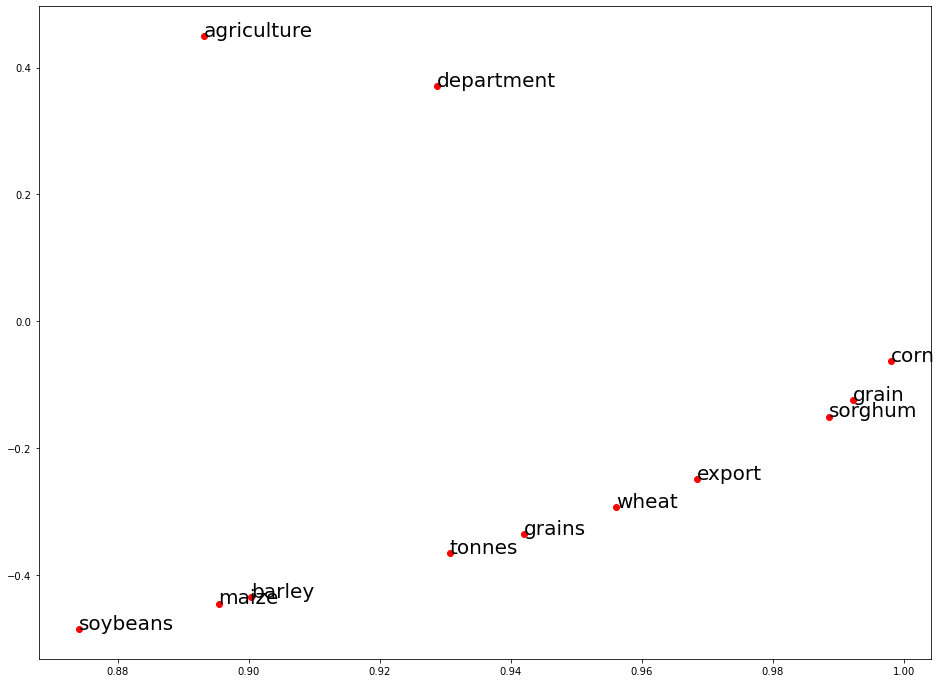

In [9]:
reuters_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['tonnes', 'grain', 'wheat',  'agriculture', 'corn', 'maize', 'export', 'department', 'barley', 'grains', 'soybeans', 'sorghum']

plot_embeddings(M_normalized, word2ind_co_occurrence, words)

### Analysis

In the two-dimensional plot above, grains normally purchased for home cooking such as barley, and soybeans are clustered together. Other grains which are normally purchased/exported in bulk (over a ton) such as wheat are clustered together. Going by this analogy, corn should probably have been clustered closer to wheat, but it does not appear so. Other entities such as agriculture and department are clustered together farther from all grains.

## Prediction-Based Word Vectors

More recently prediction-based word vectors have demonstrated better performance, such as word2vec and GloVe (which also utilizes the benefit of counts). Here, we shall explore the embeddings produced by GloVe. 

In [10]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))
    return wv_from_bin

In [11]:
# Load Word Vectors
wv_from_bin = load_embedding_model()

Loaded vocab size 400000


#### Note: If you are receiving a "reset by peer" error, rerun the cell to restart the download. 

### Reducing dimensionality of Word Embeddings
Let's directly compare the GloVe embeddings to those of the co-occurrence matrix. In order to avoid running out of memory, we will work with a sample of 10000 GloVe vectors instead.
Run the following cells to:

1. Put 10000 Glove vectors into a matrix M
2. Run `reduce_to_k_dim` (Truncated SVD function) to reduce the vectors from 200-dimensional to 2-dimensional.

In [12]:
def get_matrix_of_vectors(wv_from_bin, required_words=['tonnes', 'grain', 'wheat',  'agriculture', 'corn', 'maize', 'export', 'department', 'barley', 'grains', 'soybeans', 'sorghum']):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.index_to_key)
    print("Shuffling words ...")
    random.seed(225)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

In [13]:
# Reduce 200-Dimensional Word Embeddings to k Dimensions
M, word2ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 10012 words...
Done.


**Note: If you are receiving out of memory issues on your local machine, try closing other applications to free more memory on your device. You may want to try restarting your machine so that you can free up extra memory.

### GloVe Plot Analysis

Let's plot the embeddings for same words as before

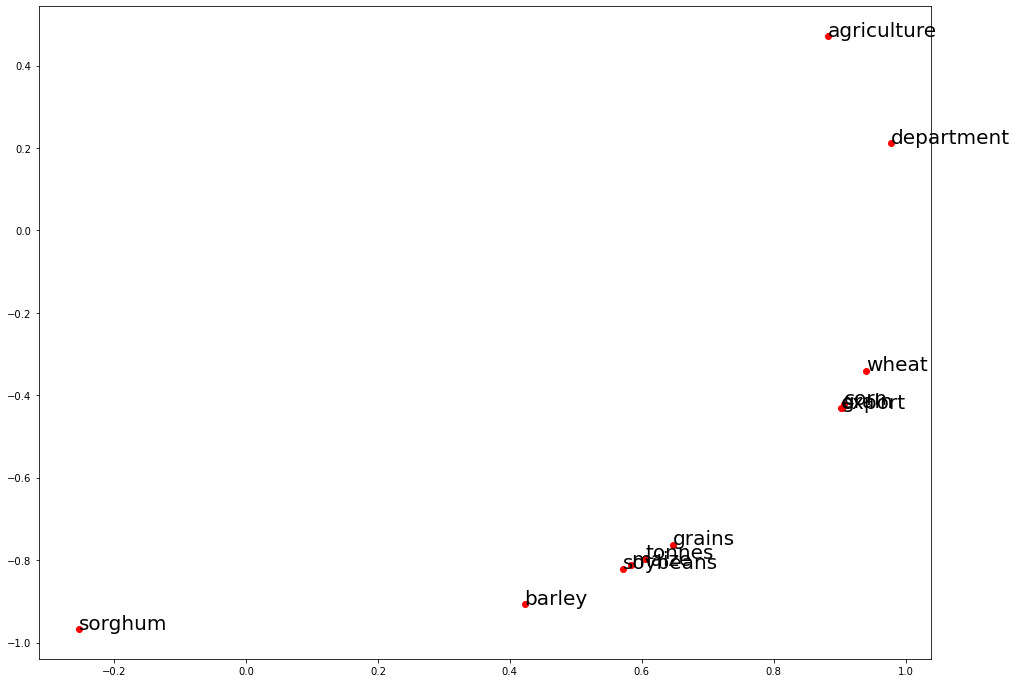

In [14]:
words = ['tonnes', 'grain', 'wheat',  'agriculture', 'corn', 'maize', 'export', 'department', 'barley', 'grains', 'soybeans', 'sorghum']
plot_embeddings(M_reduced_normalized, word2ind, words)

### Analysis

GloVe word embedding definitely seems to be better than that of the count-based vector. Like before, the grains are clustered together. Two words related to export of grains - tonnes and export - probably should have been closer together; and sorghum seems to be way too far from other grains.

### Cosine Similarity
Now that we have word vectors, we need a way to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of n-dimensional vectors as points in n-dimensional space. If we take this perspective [L1](http://mathworld.wolfram.com/L1-Norm.html) and [L2](http://mathworld.wolfram.com/L2-Norm.html) Distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors. From trigonometry we know that:

<img src="imgs/inner_product.png" width=20% style="float: center;"></img>

Instead of computing the actual angle, we can leave the similarity in terms of $similarity = cos(\Theta)$. Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

### Analogies with Word Vectors
Word vectors have been shown to *sometimes* exhibit the ability to solve analogies. 

As an example, for the analogy "man : grandfather :: woman : x" (read: man is to grandfather as woman is to x), what is x?

In the cell below, an example of how to use word vectors to find x using the `most_similar` function from the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.most_similar)__ is shown. The function finds words that are most similar to the words in the `positive` list and most dissimilar from the words in the `negative` list (while omitting the input words, which are often the most similar; see [this paper](https://www.aclweb.org/anthology/N18-2039.pdf)). The answer to the analogy will have the highest cosine similarity (largest returned numerical value).

In [15]:
# Run this cell to answer the analogy -- man : grandfather :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'grandfather'], negative=['man']))

[('grandmother', 0.7608445286750793),
 ('granddaughter', 0.7200808525085449),
 ('daughter', 0.7168302536010742),
 ('mother', 0.7151536345481873),
 ('niece', 0.7005682587623596),
 ('father', 0.6659888029098511),
 ('aunt', 0.6623408794403076),
 ('grandson', 0.6618767380714417),
 ('grandparents', 0.6446609497070312),
 ('wife', 0.6445354223251343)]


### More Analogy Examples

In [16]:
pprint.pprint(wv_from_bin.most_similar(positive=['piano', 'guitarist'], negative=['guitar']))

[('pianist', 0.7707269191741943),
 ('vocalist', 0.6886574625968933),
 ('composer', 0.6743391752243042),
 ('bassist', 0.6721004843711853),
 ('musician', 0.6620338559150696),
 ('violinist', 0.6434644460678101),
 ('keyboardist', 0.6414260268211365),
 ('drummer', 0.6330276131629944),
 ('songwriter', 0.603156328201294),
 ('singer', 0.597059428691864)]


### Bias in Word Vectors

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit in our word embeddings. Bias can be dangerous because it can reinforce stereotypes through applications that employ these models.

In [17]:
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['girl', 'toy'], negative=['boy']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['boy', 'toy'], negative=['girl']))

[('toys', 0.7094953060150146),
 ('doll', 0.5932914614677429),
 ('dolls', 0.570662260055542),
 ('barbie', 0.5407706499099731),
 ('mattel', 0.532855212688446),
 ('accessories', 0.5206909775733948),
 ('hasbro', 0.49227219820022583),
 ('jewelry', 0.47385695576667786),
 ('lego', 0.46908140182495117),
 ('apparel', 0.4613623321056366)]

[('toys', 0.7157087922096252),
 ('hasbro', 0.5164632797241211),
 ('robot', 0.4731711149215698),
 ('pet', 0.4670490026473999),
 ('manufacturer', 0.46681639552116394),
 ('mattel', 0.4582391679286957),
 ('lego', 0.45811763405799866),
 ('miniature', 0.4441472887992859),
 ('makers', 0.44298243522644043),
 ('manufactured', 0.44275349378585815)]


In [18]:
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'race-car'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'race-car'], negative=['woman']))

[('greek-born', 0.561333179473877),
 ('chicago-born', 0.5612719058990479),
 ('non-pregnant', 0.5545472502708435),
 ('chiropodist', 0.5519675016403198),
 ('divorcée', 0.5497208833694458),
 ('cisgender', 0.5449491739273071),
 ('bare-breasted', 0.5443224906921387),
 ('norwegian-born', 0.5437999963760376),
 ('headcovering', 0.5428418517112732),
 ('gold-digger', 0.5397549867630005)]

[('motor-racing', 0.5621721744537354),
 ('racecar', 0.5333659052848816),
 ('quick-thinking', 0.5083322525024414),
 ('well-travelled', 0.49568504095077515),
 ('trishaw', 0.4903923273086548),
 ('wddm', 0.4858216941356659),
 ('yōgana', 0.4847053289413452),
 ('box-to-box', 0.48346197605133057),
 ('sobeh', 0.47952255606651306),
 ('pedicab', 0.4793063700199127)]


In the analogy above, the similar words listed to woman was nowhere close to a race-car which clearly shows the bias built into the network. Flipping the role of man and woman in analogy still resulted in words very close to race-cars. Race-cars are sometimes related with men in articles and with women very rarely so, which most likely is what being reflected here

Biases in corpora are a result of the stereotypes built into the society. The articles available online often contain this bias as a consequence and they get translated into the language models. To measure this bias, we could have a *gold* test set of words and and measure the distance according to the language model to determine if such a bias exist in the system